In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
btc_data=pd.read_csv("btc_daily_data.csv")
btc_data

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-10-10 00:00:00+00:00,19446.404297,19502.619141,19423.195312,19490.929688,19490.929688,0
1,2022-10-10 01:00:00+00:00,19490.695312,19515.466797,19484.593750,19512.427734,19512.427734,211400704
2,2022-10-10 02:00:00+00:00,19510.287109,19510.287109,19471.191406,19473.847656,19473.847656,100364288
3,2022-10-10 03:00:00+00:00,19473.154297,19480.046875,19442.093750,19452.519531,19452.519531,46694400
4,2022-10-10 04:00:00+00:00,19453.076172,19472.021484,19434.292969,19472.021484,19472.021484,0
...,...,...,...,...,...,...,...
17311,2024-10-03 19:00:00+00:00,60714.792969,60989.949219,60570.183594,60984.953125,60984.953125,0
17312,2024-10-03 20:00:00+00:00,61047.957031,61075.882812,60693.765625,60736.828125,60736.828125,0
17313,2024-10-03 21:00:00+00:00,60754.742188,60947.050781,60613.316406,60811.445312,60811.445312,0
17314,2024-10-03 22:00:00+00:00,60807.699219,60961.289062,60741.824219,60893.953125,60893.953125,0


In [2]:
def calculate_heikin_ashi(df):
    df['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
    df['HA_Open'] = (df['Open'] + df['Close']) / 2
    df['HA_High'] = df[['High', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['Low', 'HA_Open', 'HA_Close']].min(axis=1)
    return df

def smooth_heikin_ashi(df, period=9):
    df=calculate_heikin_ashi(df)
    df['SHA_Close'] = df['HA_Close'].rolling(window=period).mean()
    df['SHA_Open'] = df['HA_Open'].rolling(window=period).mean()
    df['SHA_High'] = df[['High', 'SHA_Open', 'SHA_Close']].max(axis=1)
    df['SHA_Low'] = df[['Low', 'SHA_Open', 'SHA_Close']].min(axis=1)
    return df

In [3]:
def execute_trade(price_data):
    # Initialize the DataFrame
    trade_book=pd.DataFrame(columns=["Long ID","Short ID","Entry time","Exit time", "Entry Price","Exit Price","Signal", "Long Quantity","Short Quantity","RSI","ATR", "Change in PnL", "PnL", "Remarks", "Cash"])
    cash = 100000
    pnl = 0
    long_t = False
    short_t = False
    short_price=0
    long_price=0
    short_quantity=0
    long_quantity=0
    long_ID=0
    short_ID=0
    # Loop through each row in the price history dataframe
    for i in range(len(price_data)):
        # Long Trade Management
        if long_t:
            price = price_data["Open"].iloc[i]
            if price_data["Signals"].iloc[i]==2:
                long_t = False
                # Add exit signals to trade book
                price_data.loc[price_data.index[i], "Close Signals"] = -1
                price_data.loc[price_data.index[i], "Remarks"] = "Exit Long Algo"
                trade_book.loc[trade_book["Long ID"]==long_ID, "Exit time"] = price_data.index[i]
                trade_book.loc[trade_book["Long ID"]==long_ID, "Exit Price"] = price
                trade_book.loc[trade_book["Long ID"]==long_ID, "Remarks"] = "Exit Long Algo"
                # Calculate Profit/Loss
                trade_book.loc[trade_book["Long ID"]==long_ID, "Change in PnL"] = (price-long_price)*long_quantity
                trade_book.loc[trade_book["Long ID"]==long_ID, "PnL"] = (price-long_price)*long_quantity + pnl
                pnl = (price-long_price)*long_quantity + pnl
                # Update cash and tradebook
                cash*=0.999
                cash = cash + (price-long_price)*long_quantity
                trade_book.loc[trade_book["Long ID"]==long_ID, "Cash"] = cash

        # Short Trade Management
        if short_t:
            price = (price_data["Open"].iloc[i])
            if price_data["Signals"].iloc[i]==1:
                  # Exit the short position
                short_t = False
                # Add exit signals to trade book
                price_data.loc[price_data.index[i], "Close Signals"] = -2
                price_data.loc[price_data.index[i], "Remarks"] = "Exit Short Algo"
                trade_book.loc[trade_book["Short ID"]==short_ID, "Exit time"] = price_data.index[i]
                trade_book.loc[trade_book["Short ID"]==short_ID, "Exit Price"] = price
                trade_book.loc[trade_book["Short ID"]==short_ID, "Remarks"] = "Exit Short Algo"
                # Calculate Profit/Loss
                trade_book.loc[trade_book["Short ID"]==short_ID, "Change in PnL"] = -(price-short_price)*short_quantity
                trade_book.loc[trade_book["Short ID"]==short_ID, "PnL"] = -(price-short_price)*short_quantity + pnl
                pnl = -(price-short_price)*short_quantity + pnl
                # Update cash and tradebook
                cash*=0.999
                cash = cash -(price-short_price)*short_quantity
                trade_book.loc[trade_book["Short ID"]==short_ID, "Cash"] = cash
        # If no active trade (neither long nor short)
        if not long_t and not short_t:
            # Check for long or short entry signals
            if price_data["Signals"].iloc[i] == 1:
                # Create a new row with default values using pd.Series
                new_row = pd.Series([None]*15, index=trade_book.columns)
                # Add values to the new row
                new_row["Entry time"] = price_data.index[i]
                new_row["Entry Price"] = price_data["Open"].iloc[i]
                new_row["Signal"] = "Long"
                new_row["ATR"] = price_data["ATR"].iloc[i]
                new_row["RSI"] = price_data["RSI"].iloc[i]
                long_t = True
                long_price = price_data["Open"].iloc[i]
                long_ID+=1
                new_row["Long ID"] = long_ID
                cash*=0.999
                long_quantity = (cash)/price_data["Open"].iloc[i]
                new_row["Long Quantity"] = long_quantity
                trade_book = pd.concat([trade_book, new_row.to_frame().T], ignore_index=True)
                continue
            if price_data["Signals"].iloc[i] == 2:
                 # Create a new row with default values using pd.Series
                new_row = pd.Series([None]*15, index=trade_book.columns)
                # Add values to the new row
                new_row["Entry time"] = price_data.index[i]
                new_row["Entry Price"] = price_data["Open"].iloc[i]
                new_row["Signal"] = "Short"
                new_row["ATR"] = price_data["ATR"].iloc[i]
                new_row["RSI"] = price_data["RSI"].iloc[i]
                short_t = True
                short_price = price_data["Open"].iloc[i]
                short_ID+=1
                new_row["Short ID"] = short_ID
                cash*=0.999
                short_quantity = (cash)/price_data["Open"].iloc[i]
                new_row["Short Quantity"] = short_quantity
                trade_book = pd.concat([trade_book, new_row.to_frame().T], ignore_index=True)
                continue
    if long_t:
        price = price_data["Close"].iloc[-1]
        long_t = False
        trade_book.loc[trade_book["Long ID"] == long_ID, "Exit time"] = price_data.index[-1]
        trade_book.loc[trade_book["Long ID"] == long_ID, "Exit Price"] = price
        trade_book.loc[trade_book["Long ID"] == long_ID, "Remarks"] = "Exit Long (End of Data)"
        trade_book.loc[trade_book["Long ID"] == long_ID, "Change in PnL"] = (price - long_price) * long_quantity
        trade_book.loc[trade_book["Long ID"] == long_ID, "PnL"] = (price - long_price) * long_quantity + pnl
        pnl = (price - long_price) * long_quantity + pnl
        cash *= 0.999
        cash = cash + (price - long_price) * long_quantity
        trade_book.loc[trade_book["Long ID"] == long_ID, "Cash"] = cash

    elif short_t:
        price = price_data["Close"].iloc[-1]
        short_t = False
        trade_book.loc[trade_book["Short ID"] == short_ID, "Exit time"] = price_data.index[-1]
        trade_book.loc[trade_book["Short ID"] == short_ID, "Exit Price"] = price
        trade_book.loc[trade_book["Short ID"] == short_ID, "Remarks"] = "Exit Short (End of Data)"
        trade_book.loc[trade_book["Short ID"] == short_ID, "Change in PnL"] = -(price - short_price) * short_quantity
        trade_book.loc[trade_book["Short ID"] == short_ID, "PnL"] = -(price - short_price) * short_quantity + pnl
        pnl = -(price - short_price) * short_quantity + pnl
        cash *= 0.999
        cash = cash - (price - short_price) * short_quantity
        trade_book.loc[trade_book["Short ID"] == short_ID, "Cash"] = cash    

    return price_data, trade_book

In [4]:
def backtest(df,sha_len=15, adx_len=14, rsi_len=31, atr_len=14, rsi_long=70, rsi_short=35, adx_long=0, adx_short=50):
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df=smooth_heikin_ashi(df, period=sha_len).dropna()
    df=df.join(ta.adx(df['SHA_High'],df['SHA_Low'],df['SHA_Close'],length=adx_len))
    df["RSI"]=ta.rsi(df["SHA_Close"],length=rsi_len)
    df["ATR"]=ta.atr(df["SHA_High"],df["SHA_Low"],df["SHA_Close"],length=atr_len)
    df["Long Signal"] = (df["DMP_"+str(adx_len)] > df["DMN_"+str(adx_len)]) & (df["RSI"] > rsi_long) & (df["ADX_"+str(adx_len)] > adx_long)
    df["Short Signal"] = (df["DMP_"+str(adx_len)] < df["DMN_"+str(adx_len)]) & (df["RSI"] < rsi_short) & (df["ADX_"+str(adx_len)] > adx_short)
    df["Signals"]=df.apply(lambda x: 1 if x["Long Signal"] else 2 if x["Short Signal"] else 0, axis=1)
    df["Remarks"]=""
    df["Close Signals"]=0
    df.index=df["Datetime"]
    df.drop(columns=["Datetime"], inplace=True)
    price_data, trade_book = execute_trade(df)
    total_ret=trade_book.iloc[-1]["Cash"]/100000
    return trade_book, total_ret

In [6]:
sha_len= 19
adx_len= 21
rsi_len= 36
atr_len= 12
rsi_long= 68
rsi_short= 28
adx_long= 28
adx_short= 49
"""
Variables for extreme overfit returns- 55214%
sha_len= 1
adx_len= 9
rsi_len= 2
atr_len= 5
rsi_long= 15
rsi_short=89
adx_long= 7
adx_short= 15
"""

'\nVariables for extreme overfit returns- 55214%\nsha_len= 1\nadx_len= 9\nrsi_len= 2\natr_len= 5\nrsi_long= 15\nrsi_short=89\nadx_long= 7\nadx_short= 15\n'

In [7]:
trade_book,ret=backtest(btc_data, sha_len, adx_len, rsi_len, atr_len, rsi_long, rsi_short, adx_long, adx_short)

In [8]:
trade_book[5:]

,Long ID,Short ID,Entry time,Exit time,Entry Price,Exit Price,Signal,Long Quantity,Short Quantity,RSI,ATR,Change in PnL,PnL,Remarks,Cash
5,None,3,2022-12-16 16:00:00+00:00,2023-01-02 09:00:00+00:00,16984.046875,16738.748047,Short,None,7.096354,25.364471,271.792769,1740.727361,23399.058561,Exit Short Algo,122145.014357
6,4,None,2023-01-02 09:00:00+00:00,2023-02-06 04:00:00+00:00,16738.748047,22908.740234,Long,7.289844,None,68.616673,73.121406,44978.283228,68377.341789,Exit Long Algo,166879.129701
7,None,4,2023-02-06 04:00:00+00:00,2023-02-15 01:00:00+00:00,22908.740234,22158.923828,Short,None,7.277233,17.097188,221.496253,5456.589028,73833.930817,Exit Short Algo,172002.127349
8,5,None,2023-02-15 01:00:00+00:00,2023-02-22 15:00:00+00:00,22158.923828,23984.716797,Long,7.754444,None,69.257351,263.495912,14158.008615,87991.939431,Exit Long Algo,185816.303711
9,None,5,2023-02-22 15:00:00+00:00,2023-03-13 01:00:00+00:00,23984.716797,22620.462891,Short,None,7.739532,25.459347,329.934752,10558.687005,98550.626436,Exit Short Algo,196003.543925
10,6,None,2023-03-13 01:00:00+00:00,2023-04-17 19:00:00+00:00,22620.462891,29541.039062,Long,8.656213,None,69.034282,740.44295,59905.980032,158456.606468,Exit Long Algo,255517.712872
11,None,6,2023-04-17 19:00:00+00:00,2023-04-26 12:00:00+00:00,29541.039062,28963.869141,Short,None,8.640935,14.547606,392.618674,4987.287716,163443.894184,Exit Short Algo,259994.22068
12,7,None,2023-04-26 12:00:00+00:00,2023-05-02 05:00:00+00:00,28963.869141,27925.044922,Long,8.967525,None,69.997243,720.9895,-9315.682362,154128.211822,Exit Long Algo,250158.809871
13,None,7,2023-05-02 05:00:00+00:00,2023-05-04 11:00:00+00:00,27925.044922,29280.058594,Short,None,8.949266,13.751508,445.759089,-12126.377589,142001.834234,Exit Short Algo,237532.364822
14,8,None,2023-05-04 11:00:00+00:00,2023-05-08 15:00:00+00:00,29280.058594,27990.9375,Long,8.104315,None,68.07374,415.381026,-10447.444051,131554.390183,Exit Long Algo,226610.093574


In [11]:
change=trade_book["Change in PnL"]/trade_book["Cash"]
change.sort_values(ascending=False).reset_index()

,index,0
0,40,0.379692
1,6,0.269526
2,30,0.249308
3,10,0.234449
4,3,0.164137
...,...,...
59,54,-0.041724
60,26,-0.044022
61,16,-0.044276
62,14,-0.046103


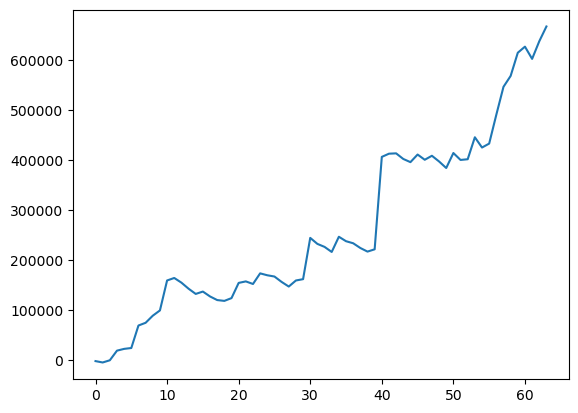

In [12]:
plt.plot(trade_book.index,trade_book["PnL"])

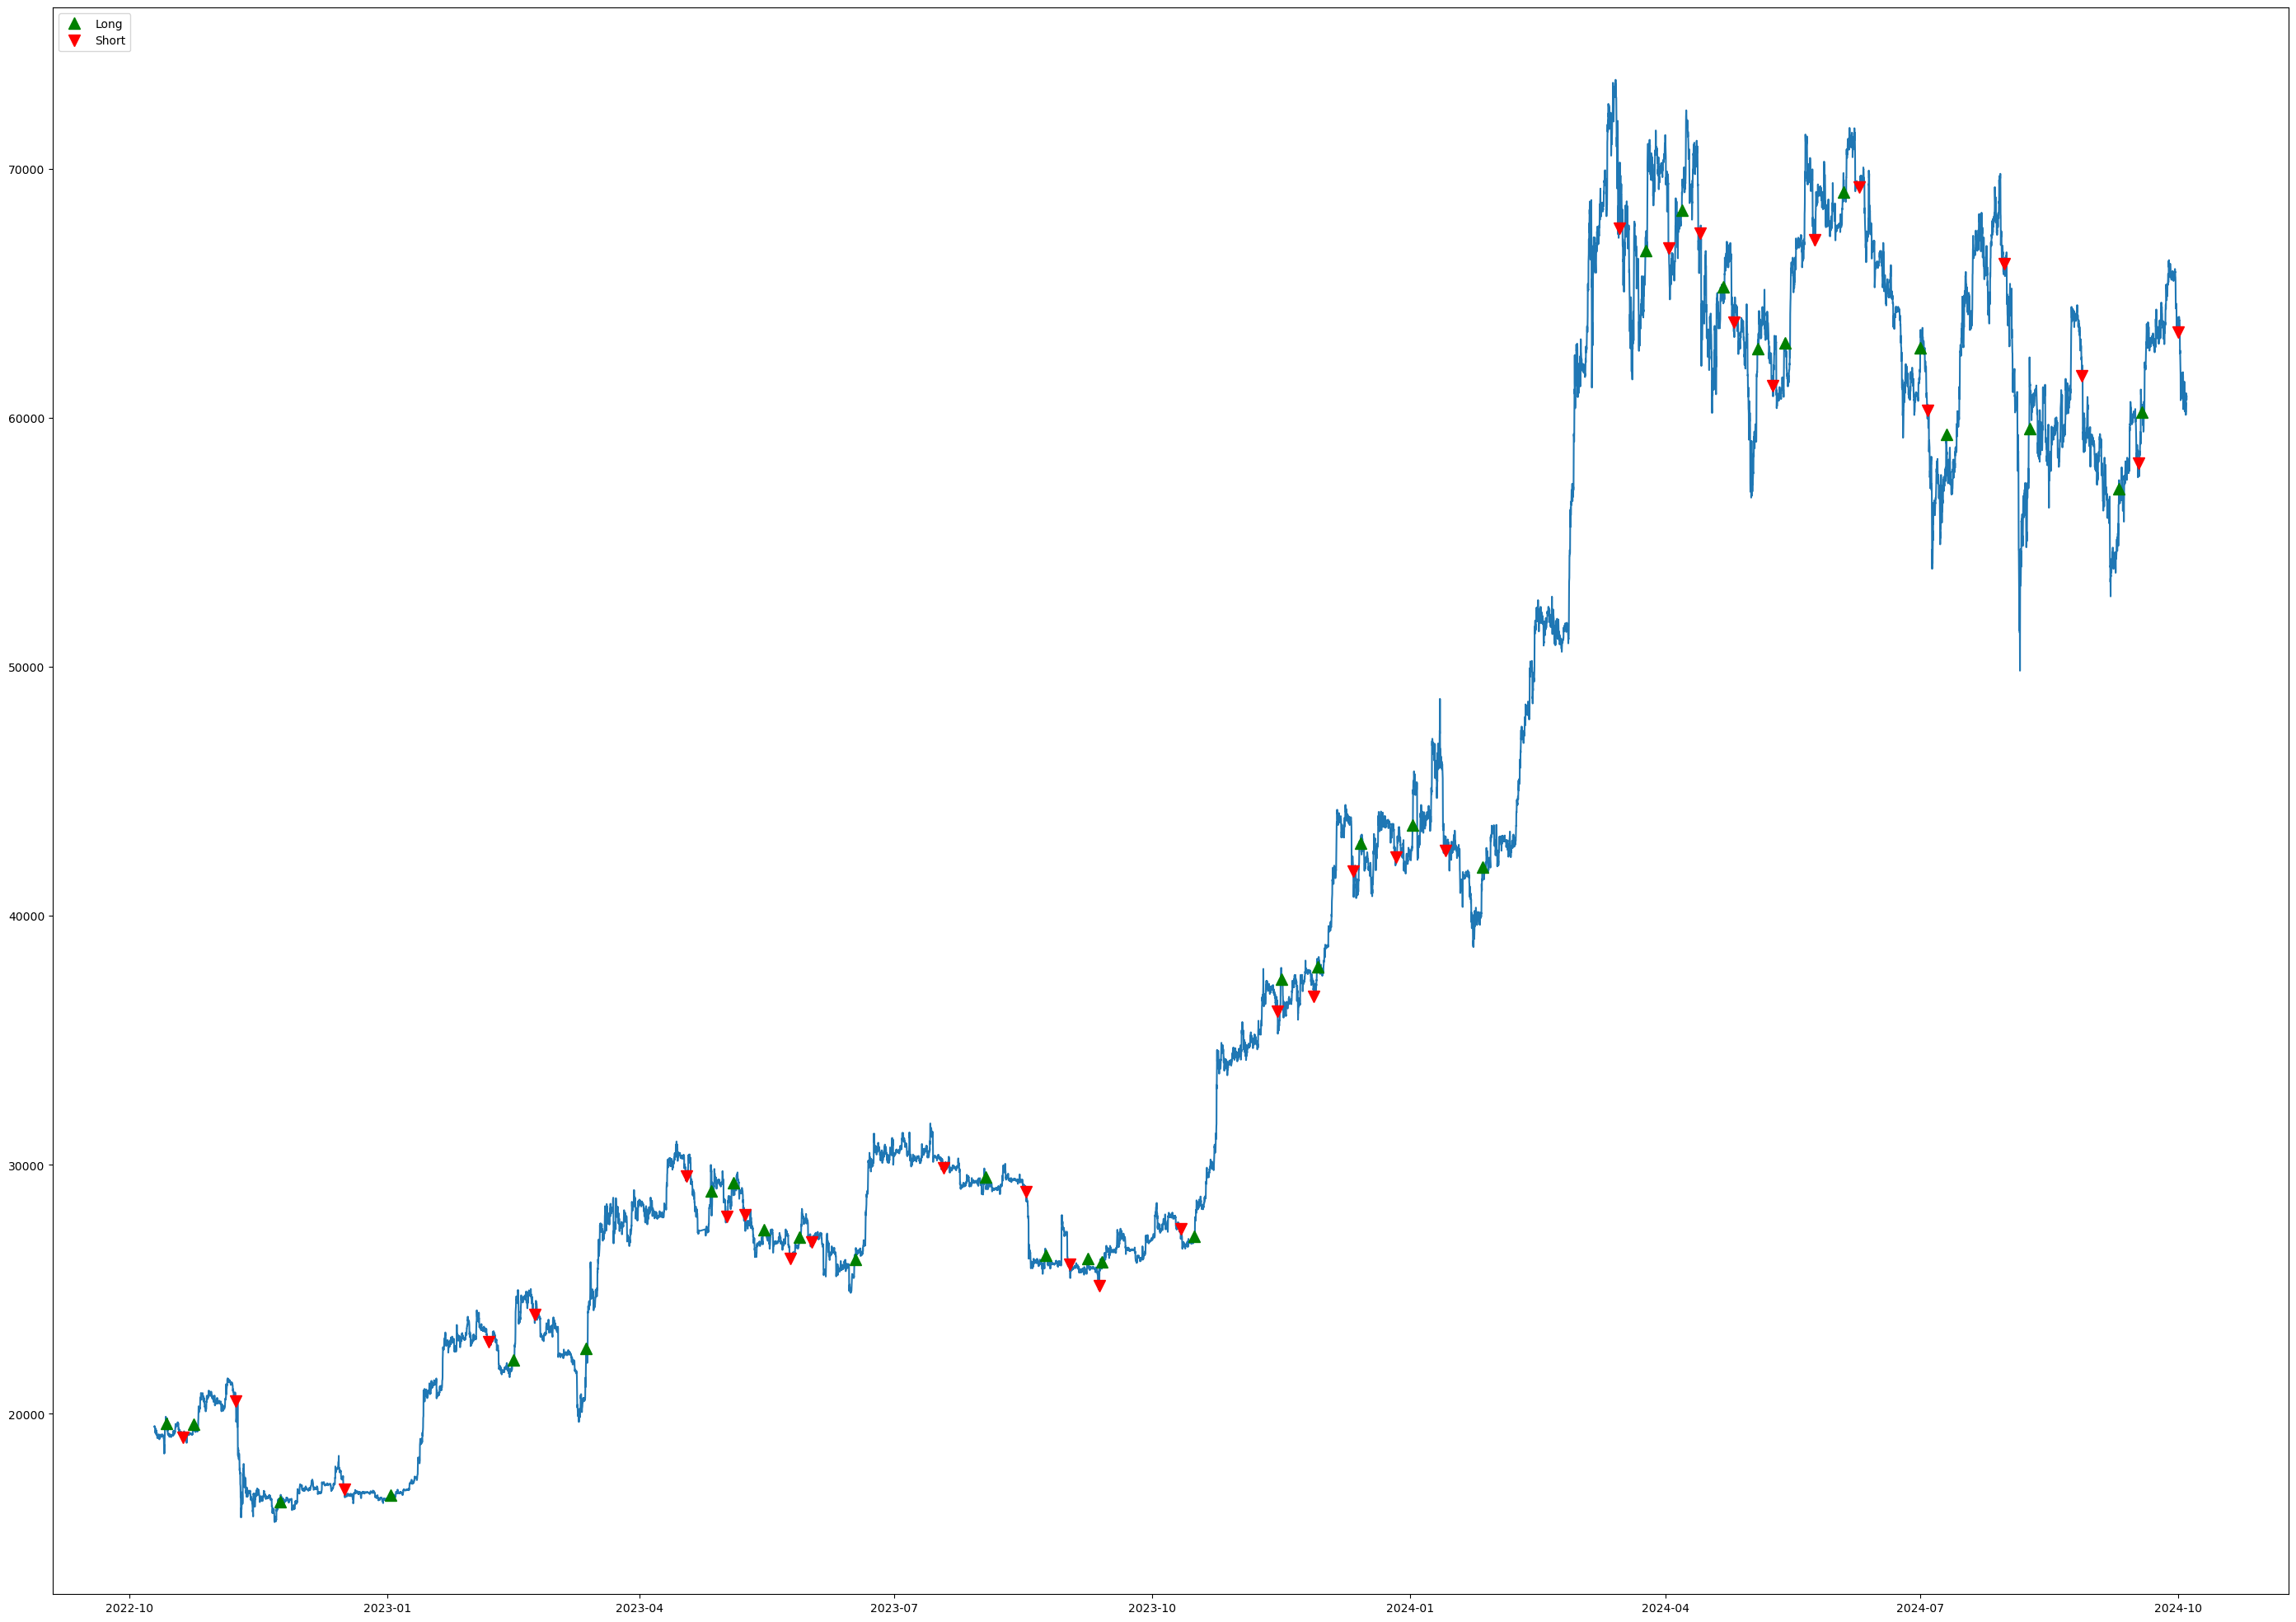

In [14]:
btc_data["Datetime"] = pd.to_datetime(btc_data["Datetime"])
trade_book["Entry time"] = pd.to_datetime(trade_book["Entry time"])
trade_book["Exit time"] = pd.to_datetime(trade_book["Exit time"])

plt.figure(figsize=(35, 25))
plt.plot(btc_data["Datetime"], btc_data["Close"])

plt.plot(trade_book["Entry time"][trade_book["Long ID"].notna()], trade_book["Entry Price"][trade_book["Long ID"].notna()],  "^", color="green", markersize=10, label="Long") 
plt.plot(trade_book["Entry time"][trade_book["Short ID"].notna()], trade_book["Entry Price"][trade_book["Short ID"].notna()], "v", color="red", markersize=10, label="Short")
plt.legend(loc="upper left")

plt.show()


In [92]:
#Genetic Algorithm based optimizer without DEAP library
import random
from tqdm import tqdm
ins=[]
num_ins=50
for i in range(num_ins):
    ins.append((random.randint(5, 30), random.randint(5, 30), random.randint(5, 50), random.randint(5, 30), random.randint(50, 90), random.randint(10, 50), random.randint(0, 50), random.randint(0, 50)))
    
num_iter=10
for i in tqdm(range(num_iter)):
    ranked_sol=[]
    for s in tqdm(ins):
        book,ret=backtest(btc_data,s[0],s[1],s[2],s[3],s[4],s[5],s[6],s[7])
        ranked_sol.append((ret, s))
    ranked_sol.sort(reverse=True)
    print(f"Gen {i} best sol: {ranked_sol[0][1]} with ret: {ranked_sol[0][0]}")
    best_sol=ranked_sol[:(num_ins//5)]
    element_1=[]
    element_2=[]
    element_3=[]
    element_4=[]
    element_5=[]
    element_6=[]
    element_7=[]
    element_8=[]
    for s in best_sol:
        element_1.append(s[1][0])
        element_2.append(s[1][1])
        element_3.append(s[1][2])
        element_4.append(s[1][3])
        element_5.append(s[1][4])
        element_6.append(s[1][5])
        element_7.append(s[1][6])
        element_8.append(s[1][7])
    newGen=[]
    for _ in range(num_ins):
        e1=int(random.choice(element_1)*random.uniform(0.8,1.2))
        e2=int(random.choice(element_2)*random.uniform(0.8,1.2))
        e3=int(random.choice(element_3)*random.uniform(0.8,1.2))
        e4=int(random.choice(element_4)*random.uniform(0.8,1.2))
        e5=int(random.choice(element_5)*random.uniform(0.8,1.2))
        e6=int(random.choice(element_6)*random.uniform(0.8,1.2))
        e7=int(random.choice(element_7)*random.uniform(0.8,1.2))
        e8=int(random.choice(element_8)*random.uniform(0.8,1.2))
        newGen.append((e1,e2,e3,e4,e5,e6,e7,e8))

 10%|████████▎                                                                          | 1/10 [01:09<10:22, 69.19s/it]

Gen 0 best sol: (9, 27, 15, 20, 70, 25, 20, 32) with ret: 4.90789185714358



 20%|████████████████▌                                                                  | 2/10 [02:17<09:08, 68.59s/it]

Gen 1 best sol: (9, 27, 15, 20, 70, 25, 20, 32) with ret: 4.90789185714358



 30%|████████████████████████▉                                                          | 3/10 [03:26<08:03, 69.05s/it]

Gen 2 best sol: (9, 27, 15, 20, 70, 25, 20, 32) with ret: 4.90789185714358



 40%|█████████████████████████████████▏                                                 | 4/10 [04:34<06:50, 68.49s/it]

Gen 3 best sol: (9, 27, 15, 20, 70, 25, 20, 32) with ret: 4.90789185714358



 50%|█████████████████████████████████████████▌                                         | 5/10 [05:45<05:46, 69.27s/it]

Gen 4 best sol: (9, 27, 15, 20, 70, 25, 20, 32) with ret: 4.90789185714358



 50%|█████████████████████████████████████████▌                                         | 5/10 [05:59<05:59, 71.88s/it]


KeyboardInterrupt: 

In [ ]:
#Alternate Optimizer

import numpy as np
from deap import base, creator, tools, algorithms
import random

# Define the parameter ranges
param_ranges = {
    'sha_len': (5, 30),
    'adx_len': (5, 30),
    'rsi_len': (5, 50),
    'atr_len': (5, 30),
    'rsi_long': (50, 90),
    'rsi_short': (10, 50),
    'adx_long': (0, 50),
    'adx_short': (0, 50)
}

# Create fitness class and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize toolbox
toolbox = base.Toolbox()

# Define gene initialization function for each parameter
for i, (param, (low, high)) in enumerate(param_ranges.items()):
        toolbox.register(f"attr_{i}", random.randint, low, high)

# Create individual and population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_0, toolbox.attr_1, toolbox.attr_2, toolbox.attr_3,
                  toolbox.attr_4, toolbox.attr_5, toolbox.attr_6, toolbox.attr_7), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define evaluation function
def evaluate(individual):
    sha_len, adx_len, rsi_len, atr_len, rsi_long, rsi_short, adx_long, adx_short = individual
    _, total_ret = backtest(btc_data, sha_len, adx_len, rsi_len, atr_len, rsi_long, rsi_short, adx_long, adx_short)
    return (total_ret,)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[r[0] for r in param_ranges.values()],
                 up=[r[1] for r in param_ranges.values()], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def optimize(population_size=50, generations=30):
    pop = toolbox.population(n=population_size)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, 
                                       ngen=generations, stats=stats, halloffame=hof, verbose=True)
    
    return hof[0], hof[0].fitness.values[0]

# Run optimization
best_params, best_return = optimize()

# Print results
param_names = list(param_ranges.keys())
print("Best parameters:")
for name, value in zip(param_names, best_params):
    print(f"{name}: {value}")
print(f"Best return: {best_return}")

# Verify the results
final_trade_book, final_total_ret = backtest(btc_data, *best_params)
print(f"Verified return: {final_total_ret}")